In [124]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot,init_notebook_mode 
from plotly.tools import make_subplots
import plotly.offline as py
init_notebook_mode(connected=True)
from sklearn import preprocessing
from time import time

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model, metrics 
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

%matplotlib inline

## Data Overview

In [2]:
train = pd.read_csv('Fraud_Data.csv')
ip_train = pd.read_csv('IpAddress_to_Country.csv')

In [3]:
train.head()

user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0

In [4]:
ip_train.head()

lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China
2              16777728.0                16778239      China
3              16778240.0                16779263  Australia
4              16779264.0                16781311      China

In [5]:
print(train.shape)
print('\n')
print(ip_train.shape)

(151112, 11)


(138846, 3)


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [41]:
train['signup_time']= pd.to_datetime(train['signup_time'])
train['purchase_time']= pd.to_datetime(train['purchase_time'])

### Missing Data

In [11]:
def missing_exploration(data):
    total= data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/ data.isnull().count() * 100).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis= 1, keys=["Total","Percent"])
    missing_data = missing_data[missing_data['Total'] > 0]
    return missing_data

In [12]:
missing_exploration(train)

Empty DataFrame
Columns: [Total, Percent]
Index: []

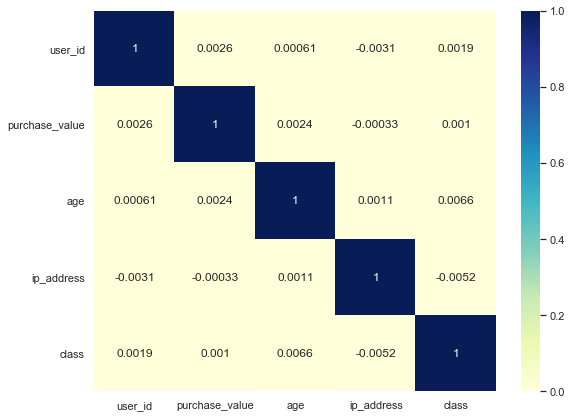

In [34]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corrmat,cmap = "YlGnBu",  annot=True ,vmin=0, vmax=1)

## EDA

###  Class

In [10]:
print(train["class"].value_counts().rename({0: 'no fraud',
                                      1: 'fraud',}))

f,ax=plt.subplots(1,2,figsize=(18,8))
train['class'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('class')
ax[0].set_ylabel('')
sns.countplot('class',data=train,ax=ax[1])
ax[1].set_title('class')
plt.show()

no fraud    136961
fraud        14151
Name: class, dtype: int64


### Gender

M    88293
F    62819
Name: sex, dtype: int64


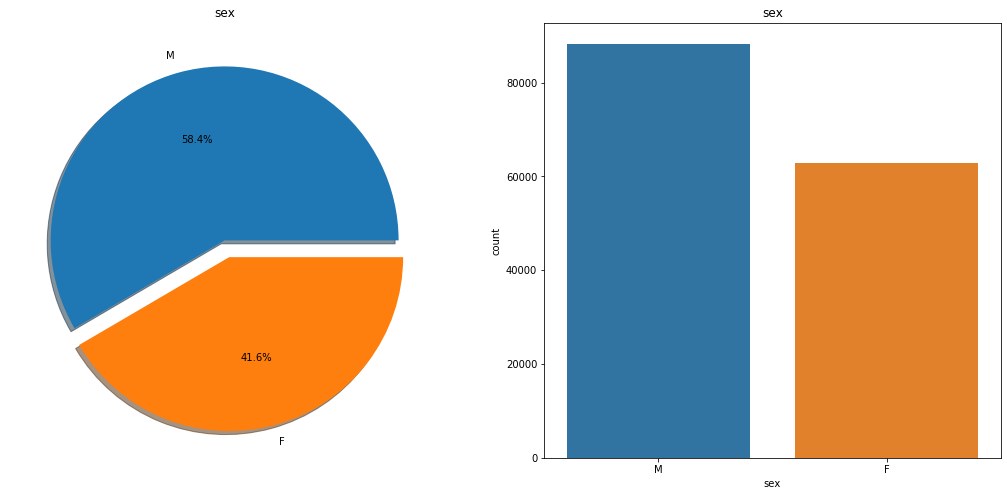

In [13]:
print(train["sex"].value_counts())

f,ax=plt.subplots(1,2,figsize=(18,8))
train['sex'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('sex')
ax[0].set_ylabel('')
sns.countplot('sex',data=train,ax=ax[1])
ax[1].set_title('sex')
plt.show()

### Age

In [14]:
train["age"].describe(percentiles = [0.05 * i for i in range(20)] + [0.99])

count    151112.000000
mean         33.140704
std           8.617733
min          18.000000
0%           18.000000
5%           20.000000
10%          22.000000
15%          24.000000
20%          25.000000
25%          27.000000
30%          28.000000
35%          29.000000
40%          30.000000
45%          31.000000
50%          33.000000
55%          34.000000
60%          35.000000
65%          36.000000
70%          37.000000
75%          39.000000
80%          40.000000
85%          42.000000
90%          45.000000
95%          48.000000
99%          55.000000
max          76.000000
Name: age, dtype: float64

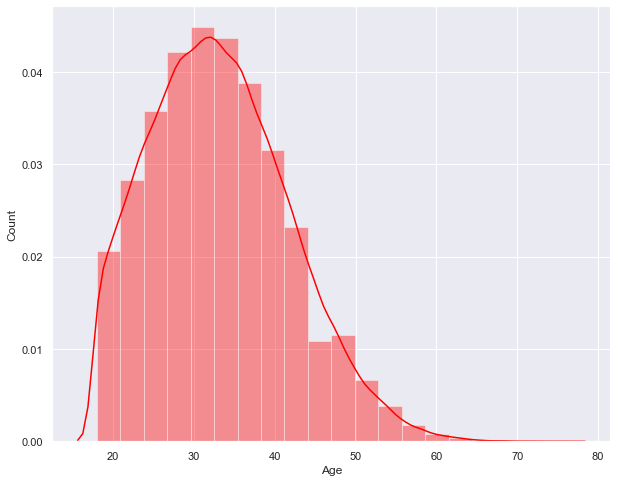

In [15]:
sns.set(style='darkgrid', font_scale=1.0, rc={"figure.figsize": [10, 8]})
sns.distplot(train['age'], bins =20, norm_hist=False,color = "red")\
.set(xlabel='Age', ylabel='Count');

In [16]:
sns.boxplot(train['age'])

### Purchase Value

In [24]:
train["purchase_value"].describe(percentiles = [0.05 * i for i in range(20)] + [0.99])

count    151112.000000
mean         36.935372
std          18.322762
min           9.000000
0%            9.000000
5%           12.000000
10%          15.000000
15%          17.000000
20%          20.000000
25%          22.000000
30%          25.000000
35%          27.000000
40%          30.000000
45%          32.000000
50%          35.000000
55%          37.000000
60%          40.000000
65%          43.000000
70%          45.000000
75%          49.000000
80%          52.000000
85%          57.000000
90%          62.000000
95%          70.000000
99%          87.000000
max         154.000000
Name: purchase_value, dtype: float64

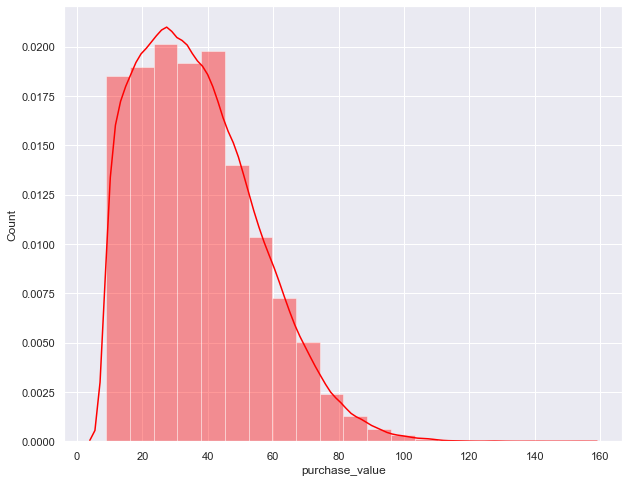

In [26]:
sns.set(style='darkgrid', font_scale=1.0, rc={"figure.figsize": [10, 8]})
sns.distplot(train['purchase_value'], bins =20, norm_hist=False,color = "red")\
.set(xlabel='purchase_value', ylabel='Count');

### Source, Brower

In [17]:
train['source'].value_counts()

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

In [18]:
train['browser'].value_counts()

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

### Multi Feature

#### Class with Gender

In [21]:
pd.crosstab(train['class'],train['sex'],margins=True).style.background_gradient(cmap='summer_r')

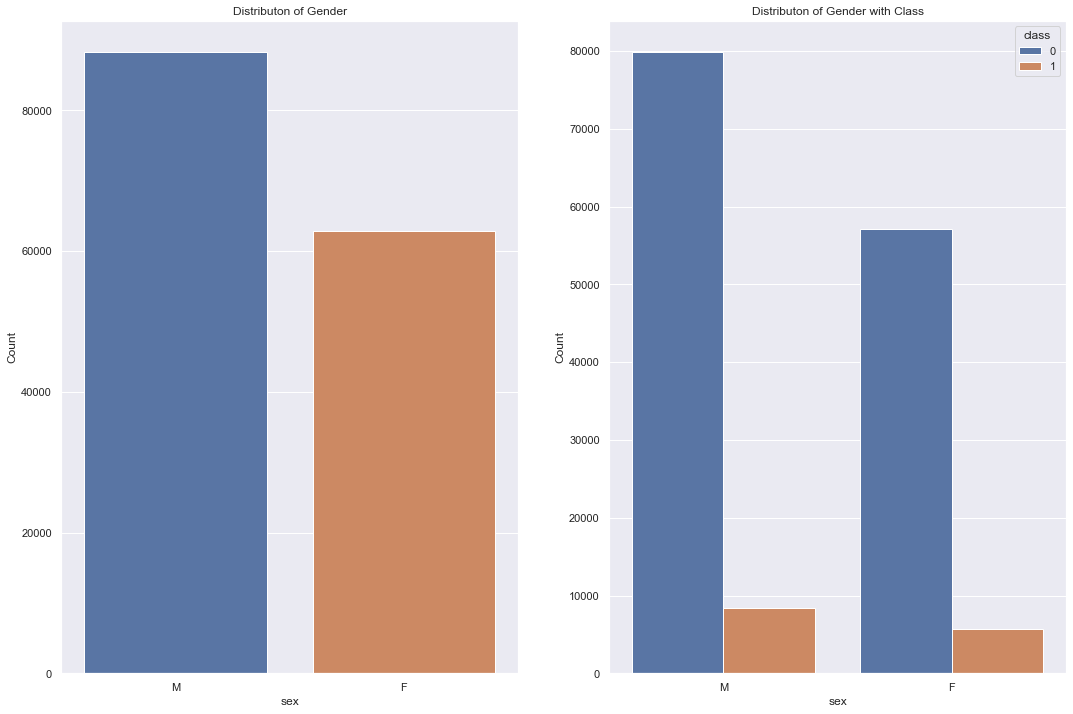

In [23]:
f, ax = plt.subplots(1,2, figsize = (18,12))
sns.countplot(x = 'sex', data = train, ax = ax[0])
ax[0].set_title("Distributon of Gender")
ax[0].set_ylabel("Count")
sns.countplot(x = 'sex', hue= 'class',data = train, ax = ax[1])
ax[1].set_title("Distributon of Gender with Class")
ax[1].set_ylabel("Count")
plt.show()

#### Class with Age

In [28]:
sns.set(style='darkgrid', font_scale=1.0, rc={"figure.figsize": [18, 10]})
sns.distplot(train[train['class']==0].age,bins=20, kde=False, color='b', label='no fraud')
sns.distplot(train[train['class']==1].age,bins=20, kde=False, color='r',label='fraud')
plt.legend()

In [33]:
pd.crosstab(train['age'],train['class'],margins=True).sort_values('All', ascending = False).style.background_gradient(cmap='summer_r')

In [36]:
pd.crosstab(train['source'], train['class'], margins=True).style.background_gradient(cmap='summer_r')

In [37]:
pd.crosstab(train['browser'], train['class'], margins=True).style.background_gradient(cmap='summer_r')

In [42]:
train['diffdate'] = train['purchase_time'] - train['signup_time']

In [50]:
train['diffdate1'] = train["diffdate"] / np.timedelta64(1, 'h')

In [52]:
train.head()

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0   

          diffdate    diffdate1  
0 52 days 03:51:22  1251.856111  
1  0 days 04:59:04     4.984444  
2  0 days 00:00:01     0.000278  
3  5 days 16:41:25   136.690278  
4 50 days 11:31:01  1211.516944

In [60]:
pd.crosstab(train['purchase_value'],train['class'],margins=True).sort_values('All', ascending = False).style.background_gradient(cmap='summer_r')

In [61]:
pd.crosstab(train['purchase_value'],train['sex'],margins=True).sort_values('All', ascending = False).style.background_gradient(cmap='summer_r')

In [67]:
pd.crosstab(train['device_id'],[train['class'], train['source']],margins=True).sort_values('All', ascending = False).head(30).style.background_gradient(cmap='summer_r')

In [76]:
train1 = train.groupby([train['device_id']])['class'].count()

In [90]:
train1 = train1.to_frame().reset_index()

In [92]:
train1.columns = ['device_id','num_trans_device']

In [94]:
train = pd.merge(train,train1, how = 'left', on = 'device_id')

In [95]:
train.head()

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0   

          diffdate    diffdate1  num_trans_device  
0 52 days 03:51:22  1251.856111                 1  
1  0 days 04:59:04     4.984444                 1  
2  0 days 00:00:01     0.000278                12  
3  5 days 16:41:25   136.690278                 1  
4 50 days 11:31:01  1211.516944                 1

In [96]:
pd.crosstab(train['num_trans_device'], train['class'], margins=True).sort_values('All', ascending = False).style.background_gradient(cmap='summer_r')

In [101]:
data = []
for a in range(2):
    df = train.loc[train['class'] == a]

    data.append(go.Scatter(
        x = df['num_trans_device'].value_counts().sort_index().index,
        y = df['num_trans_device'].value_counts().sort_index().values,
        name = str(a)
    ))
    
layout = go.Layout(dict(title = "Class trends by num_trans_device",
                  xaxis = dict(title = 'num_trans_device'),
                  yaxis = dict(title = 'Counts'),
                  )
                  )
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [104]:
train.loc[ train['num_trans_device'] <= 4, 'trans_num']          = 'No'
train.loc[(train['num_trans_device'] > 4) , 'trans_num']        = 'Yes'

## Data Preprocess

In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   user_id           151112 non-null  int64          
 1   signup_time       151112 non-null  datetime64[ns] 
 2   purchase_time     151112 non-null  datetime64[ns] 
 3   purchase_value    151112 non-null  int64          
 4   device_id         151112 non-null  object         
 5   source            151112 non-null  object         
 6   browser           151112 non-null  object         
 7   sex               151112 non-null  object         
 8   age               151112 non-null  int64          
 9   ip_address        151112 non-null  float64        
 10  class             151112 non-null  int64          
 11  diffdate          151112 non-null  timedelta64[ns]
 12  diffdate1         151112 non-null  float64        
 13  num_trans_device  151112 non-null  int64    

In [107]:
numerical = ['age','num_trans_device','purchase_value','diffdate1']

In [108]:
train['diffdate1'] = np.log1p(train['diffdate1'])

In [109]:
min_max_scaler = preprocessing.MinMaxScaler()

In [110]:
train[numerical] = min_max_scaler.fit_transform(train[numerical])

In [112]:
train.head()

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11        0.172414   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54        0.048276   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45        0.041379   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50        0.241379   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53        0.206897   

       device_id source browser sex       age    ip_address  class  \
0  QVPSPJUOCKZAR    SEO  Chrome   M  0.362069  7.327584e+08      0   
1  EOGFQPIZPYXFZ    Ads  Chrome   F  0.603448  3.503114e+08      0   
2  YSSKYOSJHPPLJ    SEO   Opera   M  0.603448  2.621474e+09      1   
3  ATGTXKYKUDUQN    SEO  Safari   M  0.396552  3.840542e+09      0   
4  NAUITBZFJKHWW    Ads  Safari   M  0.465517  4.155831e+08      0   

          diffdate  diffdate1  num_trans_device trans_num  
0 52 days 03:51:22   7.133181          0.000000        No  
1  0 days 04:59:04   1.789164          0.000000        No  
2  0 days 00:00:01   0.000278          0.578947       Yes  
3  5 days 16:41:25   4.925007          0.000000        No  
4 50 days 11:31:01   7.100454          0.000000        No

In [113]:
drop_feature = ['user_id','signup_time','purchase_time','device_id','ip_address','diffdate']
train = train.drop(drop_feature, axis=1)

In [115]:
train = pd.get_dummies(train)

In [116]:
train.head()

purchase_value       age  class  diffdate1  num_trans_device  source_Ads  \
0        0.172414  0.362069      0   7.133181          0.000000           0   
1        0.048276  0.603448      0   1.789164          0.000000           1   
2        0.041379  0.603448      1   0.000278          0.578947           0   
3        0.241379  0.396552      0   4.925007          0.000000           0   
4        0.206897  0.465517      0   7.100454          0.000000           1   

   source_Direct  source_SEO  browser_Chrome  browser_FireFox  browser_IE  \
0              0           1               1                0           0   
1              0           0               1                0           0   
2              0           1               0                0           0   
3              0           1               0                0           0   
4              0           0               0                0           0   

   browser_Opera  browser_Safari  sex_F  sex_M  trans_num_No  trans_num_Yes  
0              0               0      0      1             1              0  
1              0               0      1      0             1              0  
2              1               0      0      1             0              1  
3              0               1      0      1             1              0  
4              0               1      0      1             1              0

In [117]:
train.shape

(151112, 17)

## Model

In [118]:
y = train['class']
x = train.drop('class', axis=1)

In [120]:
x_train, x_test , y_train, y_test= train_test_split(x,y,test_size=0.2,random_state = 12)

In [121]:
print(x_train.shape)
print(y_train.shape)

(120889, 16)
(120889,)


In [122]:
print(x_test.shape)
print(y_test.shape)

(30223, 16)
(30223,)


In [131]:
def train_predict(model, X_train, y_train, X_test, y_test): 

    
    results = {}
    
    
    start = time() # Get start time
    model.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the total training time
    results['train_time'] = end - start
        
    
    start = time() # Get start time
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the train
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the train
    results['f_train'] = fbeta_score(y_train, predictions_train, 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    return results

In [135]:
clf_A  = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.8, learning_rate = 0.01,
                max_depth = 5, alpha = 10, n_estimators = 10)
clf_B = GradientBoostingClassifier(random_state=0)



results = {}
for clf in [clf_A, clf_B]:
     results[clf] = train_predict(clf, x_train, y_train, x_test, y_test)

In [136]:
results

{XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8, gamma=0,
               learning_rate=0.01, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1): {'train_time': 0.8165469169616699,
  'pred_time': 0.08996224403381348,
  'acc_train': 0.9568033485263341,
  'acc_test': 0.9560268669556298,
  'f_train': 0.8531785081676836,
  'f_test': 0.8520703472840606},
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,